In [1]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import shutil
from helper import *
from PIL import Image
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
bd_configPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']
bd = Detector(bd_configPath, bd_weightsPath, bd_classes)

human_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
human_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

extract_dir = "/Users/arpitsharma/Downloads/Extract"
organize_dir = "/Users/arpitsharma/Downloads/organized_photos"

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
path_to_file = "data/DSC0690.jpg"

img_cv2 = cv2.imread(path_to_file)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
img_pil = Image.open(path_to_file)

runner = Runner(filename=path_to_file, img=img_cv2)

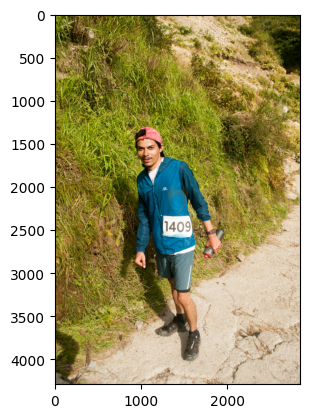

In [4]:
plt.imshow(img_cv2)

In [5]:
inputs = human_processor(images=img_cv2, return_tensors="pt")
outputs = human_model(**inputs)

In [7]:
target_sizes = torch.tensor([img_cv2.shape[:2]])
results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [8]:
results

{'scores': tensor([0.9996], grad_fn=<IndexBackward0>),
 'labels': tensor([1]),
 'boxes': tensor([[ 896.3618, 1292.2972, 1956.6892, 4013.9375]],
        grad_fn=<IndexBackward0>)}

In [9]:
score, label, box = results["scores"], results["labels"], results["boxes"]

i = 0

if human_model.config.id2label[label[i].item()] == "person":
    hbox = [int(i) for i in box[i].tolist()]
    runner.body_location = hbox
    faces = runner.detect_face()
    human_cropped_pil = img_pil.crop((hbox[0], hbox[1], hbox[2], hbox[3]))
    human_cropped_cv2 = img_cv2[hbox[1]:hbox[3], hbox[0]:hbox[2]]
else:
    print(False)

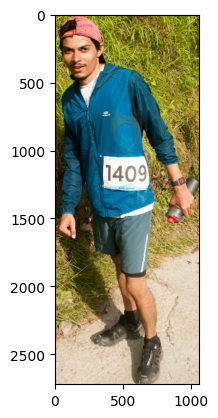

In [10]:
plt.imshow(human_cropped_cv2)

In [11]:
res = runner.draw_rectangle(img_cv2)

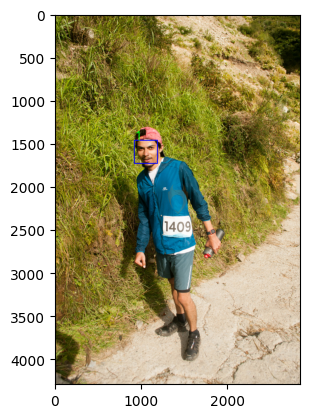

In [12]:
plt.imshow(res)

In [13]:
bib_detections = bd.detect(human_cropped_cv2, 0.1)

In [14]:
bib_detections

[['bib', [352, 1104, 320, 198]]]

In [15]:
(x, y, w, h) = bib_detections[0][1]
runner.bib_location = (hbox[0] + x, hbox[1] + y, hbox[0] + x + w, hbox[1] + y + h)

In [16]:
(x1, y1, x2, y2) = runner.bib_location

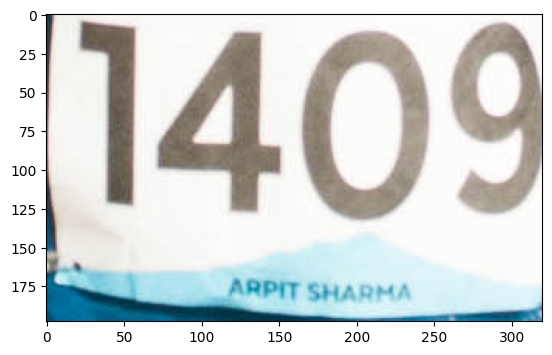

In [17]:
plt.imshow(img_cv2[y1:y2, x1:x2])

In [18]:
bib_number = process_image(img_cv2[y1:y2, x1:x2])
print(bib_number)

/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1409


In [19]:
runner.bib_number = bib_number
print(runner)

data/DSC0690.jpg:1409:[896, 1292, 1956, 4013]:[(918, 1463, 1186, 1731)]:(1248, 2396, 1568, 2594)


In [20]:
runner.embeddings()

[array([-0.02376707,  0.11022224,  0.11338821,  0.0010837 , -0.0694064 ,
        -0.07253735, -0.05427328, -0.05202284,  0.11837134, -0.04772089,
         0.19081016, -0.01346485, -0.18996689, -0.00707104, -0.03193778,
         0.09815183, -0.11845666, -0.07157193, -0.11825532, -0.08866381,
         0.00831233,  0.07477744,  0.02654262,  0.00871016, -0.07934568,
        -0.30963305, -0.09763344, -0.09985614,  0.12039592, -0.10478561,
        -0.01806899,  0.02918743, -0.16738603, -0.00864372,  0.02046009,
         0.01584242,  0.00495742, -0.07740279,  0.18103403, -0.013776  ,
        -0.16768537, -0.03929237,  0.02822574,  0.22231516,  0.21489462,
        -0.01278807,  0.00097223, -0.06071252,  0.03720766, -0.2028286 ,
         0.01775471,  0.1662102 ,  0.08448159,  0.11974028,  0.04670002,
        -0.16130109,  0.01445118,  0.0791164 , -0.14645676,  0.02623869,
         0.02095214, -0.11974818, -0.0553582 , -0.06989138,  0.16936946,
         0.04757701, -0.08054347, -0.1729247 ,  0.1

In [6]:
# for filename in ["/Users/arpitsharma/Downloads/TBT_ERROR/TBT 2023-1267.jpg"]:

filename = "TBT 2023-1267.jpg"
extract_dir = "/Users/arpitsharma/Downloads/TBT_ERROR/"

img_cv2 = cv2.imread(os.path.join(extract_dir, filename))
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
img_pil = Image.open(os.path.join(extract_dir, filename))

inputs = human_processor(images=img_pil, return_tensors="pt")
outputs = human_model(**inputs)

target_sizes = torch.tensor([img_pil.size[::-1]])
results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
print(results)

#     for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
score, label, box = results["scores"], results["labels"], results["boxes"]


if human_model.config.id2label[label[2].item()] == "person" and round(score[2].item(), 3) > 0.90:
    hbox = [int(i) for i in box[2].tolist()]
    human_cropped_pil = img_pil.crop((hbox[0], hbox[1], hbox[2], hbox[3]))
    human_cropped_cv2 = img_cv2[hbox[1]:hbox[3], hbox[0]:hbox[2]]
    human_cropped_pil.show()
    print("Person")
    bib_detections = bd.detect(human_cropped_cv2, 0.25)
#             print(filename, bib_detections)
    print(bib_detections)
    if len(bib_detections):
        (x, y, w, h) = bib_detections[0][1]

        cropped_bib_pil = human_cropped_pil.crop((x, y, x + w, y + h))
        cropped_bib_cv2 = human_cropped_cv2[y:y+h, x:x+w]

        bib_number = process_image(cropped_bib_pil)
        print(filename, bib_number)

{'scores': tensor([0.9736, 0.9886, 0.9995, 0.9727], grad_fn=<IndexBackward0>), 'labels': tensor([44, 39,  1, 27]), 'boxes': tensor([[1514.1473, 4134.8467, 2069.8052, 4865.8086],
        [ 695.6212, 2844.0520, 1064.7642, 7370.8047],
        [ 387.6540, 1721.0027, 4893.4985, 7266.0698],
        [1099.1212, 3110.3914, 3259.5806, 5408.7959]],
       grad_fn=<IndexBackward0>)}
Person
[['bib', [1507, 4439, 885, 463]]]


/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TBT 2023-1267.jpg 3051
